# Predicting Fuel Efficiency of Vehicles

This notebook builds an end to end machine learning model to predict fuel consumption of 70s and 80s vehicles.

1. **Data Collection** - I'll be using the classic [Auto MPG dataset](http://archive.ics.uci.edu/ml/datasets/Auto+MPG) from UCI ML Repository.
2. **Problem Statement** - Frame the problem based on the dataset description and initial exploration.
3. **Data Exploration** - Carry our exploratory analysis to figure out the important features and creating new combination of features.
4. **Data Preparation** - Create a pipeline of tasks to transform the data to be loaded into our ML models.
5. **Modelling** - Training a few models to evaluate their predictions using cross-validation.
6. **Hyperparameter Tuning** - Fine tune the hyperparameters for the models that showed promising results.
7. **Deploy the Model using a web service** - Using **Flask web framework** to deploy our trained model on **Heroku**

## Data Collection

**Import the tools**

In [3]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

In [4]:
# # download the data
# !wget "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

In [5]:
# Reading the data in a dataframe

# define columns
cols = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

auto = pd.read_csv('auto-mpg.data', names=cols, na_values = "?",
                comment = '\t',
                sep= " ",
                skipinitialspace=True)

data = auto.copy()

In [6]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Problem Statement:

The data contains MPG variable which is continuous data and tells us about the efficiency of fuel consumption of a vehicle in 70s and 80s.

Our aim here is to predict the MPG value for a vehicle given we have other attributes of that vehicle.



## Exploratory Data Analysis
* Check for data type of columns
* Check for null values.
* Check for outliers
* Look for the category distribution in categorical columns
* Plot for correlation
* Look for new variables

In [7]:
##checking the data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [8]:
## checking for all the null values
data.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
# summary statistics of quantitative variables
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [10]:
data["Origin"].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

<AxesSubplot:xlabel='Horsepower'>

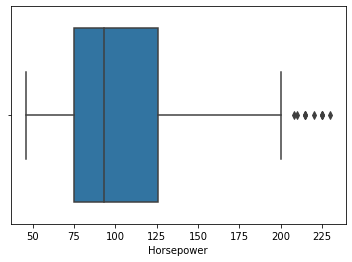

In [11]:
# let's visualize
sns.boxplot(x=data['Horsepower'])

In [12]:
# # imputing the values with median
# median = data['Horsepower'].median()
# data['Horsepower'] = data['Horsepower'].fillna(median)
# data.info()

In [13]:
data.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [14]:
# category distribution
data["Cylinders"].value_counts() / len(data)

4    0.512563
8    0.258794
6    0.211055
3    0.010050
5    0.007538
Name: Cylinders, dtype: float64

In [15]:
data['Origin'].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

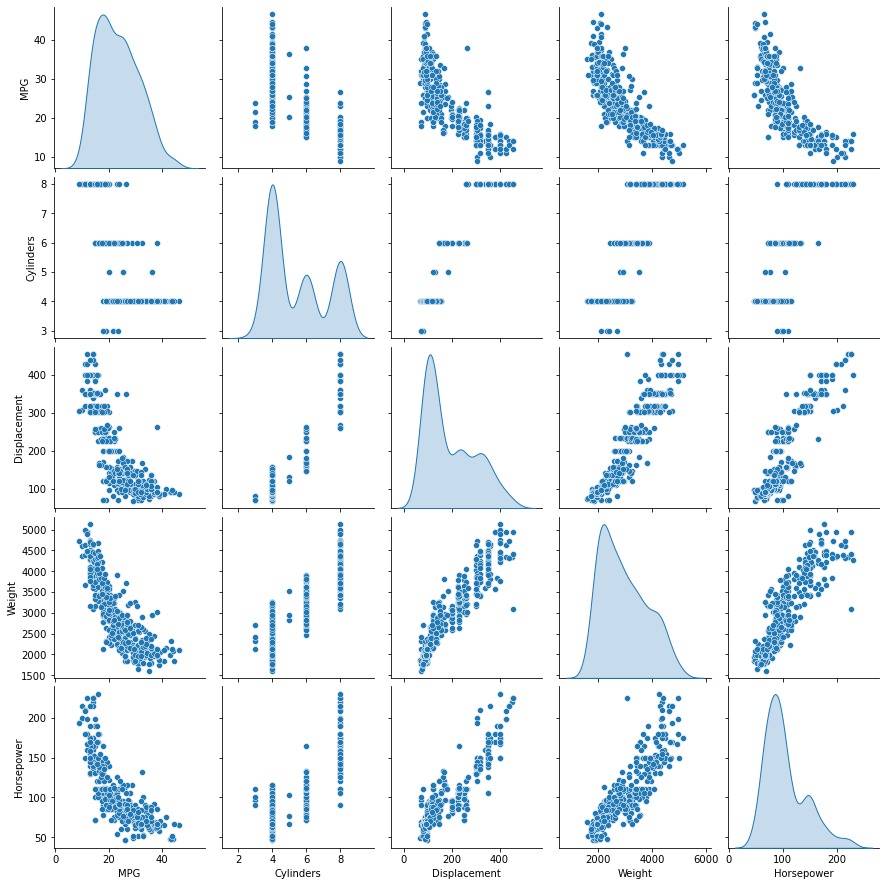

In [16]:
# visualize correlaions through pairplot
sns.pairplot(data[["MPG", "Cylinders", "Displacement", "Weight", "Horsepower"]], diag_kind="kde")

### Checking correlation matrix w.r.t. MPG

In [17]:
corr_matrix = data.corr()
corr_matrix['MPG'].sort_values(ascending=False)

MPG             1.000000
Model Year      0.579267
Origin          0.563450
Acceleration    0.420289
Cylinders      -0.775396
Horsepower     -0.778427
Displacement   -0.804203
Weight         -0.831741
Name: MPG, dtype: float64

#### Testing new variables by checking their correlation w.r.t. MPG

* Displacement on Power
* Weight on cylinder
* Acceleration on power
* Acceleration on cylinder

In [18]:
# testing new variables by checking their correlation w.r.t. MPG

# create a copy of dataframe
data_trans = data.copy()

# add new features
data_trans['displacement_on_power'] = data_trans['Displacement'] / data_trans['Horsepower']
data_trans['weight_on_cylinder'] = data_trans['Weight'] / data_trans['Cylinders']
data_trans['acceleration_on_power'] = data_trans['Acceleration'] / data_trans['Horsepower']
data_trans['acceleration_on_cyl'] = data_trans['Acceleration'] / data_trans['Cylinders']

corr_matrix = data_trans.corr()
corr_matrix['MPG'].sort_values(ascending=False)

MPG                      1.000000
acceleration_on_cyl      0.732133
acceleration_on_power    0.710556
Model Year               0.579267
Origin                   0.563450
Acceleration             0.420289
weight_on_cylinder      -0.020778
displacement_on_power   -0.572176
Cylinders               -0.775396
Horsepower              -0.778427
Displacement            -0.804203
Weight                  -0.831741
Name: MPG, dtype: float64

In [19]:
# reminding ourselves of data
data_trans.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,displacement_on_power,weight_on_cylinder,acceleration_on_power,acceleration_on_cyl
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,2.361538,438.000,0.092308,1.5000
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,2.121212,461.625,0.069697,1.4375
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,2.120000,429.500,0.073333,1.3750
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,2.026667,429.125,0.080000,1.5000
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,2.157143,431.125,0.075000,1.3125


In [20]:
data_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MPG                    398 non-null    float64
 1   Cylinders              398 non-null    int64  
 2   Displacement           398 non-null    float64
 3   Horsepower             392 non-null    float64
 4   Weight                 398 non-null    float64
 5   Acceleration           398 non-null    float64
 6   Model Year             398 non-null    int64  
 7   Origin                 398 non-null    int64  
 8   displacement_on_power  392 non-null    float64
 9   weight_on_cylinder     398 non-null    float64
 10  acceleration_on_power  392 non-null    float64
 11  acceleration_on_cyl    398 non-null    float64
dtypes: float64(9), int64(3)
memory usage: 37.4 KB


In [21]:
data_trans.isnull().sum()

MPG                      0
Cylinders                0
Displacement             0
Horsepower               6
Weight                   0
Acceleration             0
Model Year               0
Origin                   0
displacement_on_power    6
weight_on_cylinder       0
acceleration_on_power    6
acceleration_on_cyl      0
dtype: int64

## Data Preparation

* Handling Categorical Functions - **OneHotEncoder**
* Data Cleaning - **Imputer**
* Attribute Addition - Adding custom transformation
* Setting up Data Transformation Pipeline for numerical and categorical column.

### Split the data

There are many ways to split the data into training and testing sets but we want our test set to represent the overall population and not just a few specific categories. Thus, instead of using simple and common `train_test_split()` method from sklearn, we use stratified sampling.

> **Stratified Sampling** — We create homogeneous subgroups called strata from the overall population and sample the right number of instances to each stratum to ensure that the test set is representative of the overall population.

**Splitting the data using `train_test_split`**

In [22]:
# split the data into training and test sets

from sklearn.model_selection import train_test_split
tts_train_set, tts_test_set = train_test_split(data, test_size=0.2, random_state=42)

In [23]:
tts_train_set.shape, tts_test_set.shape

((318, 8), (80, 8))

In [24]:
tts_train_set['Cylinders'].value_counts() / len(tts_train_set)

4    0.509434
8    0.248428
6    0.220126
3    0.012579
5    0.009434
Name: Cylinders, dtype: float64

In [25]:
tts_test_set["Cylinders"].value_counts() / len(tts_test_set)

4    0.525
8    0.300
6    0.175
Name: Cylinders, dtype: float64

**Splitting the data using Stratified sampling**

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["Cylinders"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [27]:
strat_test_set.shape

(80, 8)

In [28]:
# Cylinder category distribution in training set
strat_train_set['Cylinders'].value_counts() / len(strat_train_set)

4    0.512579
8    0.257862
6    0.210692
5    0.009434
3    0.009434
Name: Cylinders, dtype: float64

In [29]:
# Cylinder category distribution in testing set
strat_test_set["Cylinders"].value_counts() / len(strat_test_set)

4    0.5125
8    0.2625
6    0.2125
3    0.0125
Name: Cylinders, dtype: float64

In [30]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 145 to 362
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           318 non-null    float64
 1   Cylinders     318 non-null    int64  
 2   Displacement  318 non-null    float64
 3   Horsepower    314 non-null    float64
 4   Weight        318 non-null    float64
 5   Acceleration  318 non-null    float64
 6   Model Year    318 non-null    int64  
 7   Origin        318 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 22.4 KB


In [31]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 128 to 240
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           80 non-null     float64
 1   Cylinders     80 non-null     int64  
 2   Displacement  80 non-null     float64
 3   Horsepower    78 non-null     float64
 4   Weight        80 non-null     float64
 5   Acceleration  80 non-null     float64
 6   Model Year    80 non-null     int64  
 7   Origin        80 non-null     int64  
dtypes: float64(5), int64(3)
memory usage: 5.6 KB


### Segregating Target and Feature variables

In [32]:
train_data = strat_train_set.drop("MPG", axis=1)
train_labels = strat_train_set["MPG"]
train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,3
151,4,79.0,67.0,2000.0,16.0,74,2
388,4,156.0,92.0,2585.0,14.5,82,1
48,6,250.0,88.0,3139.0,14.5,71,1
114,4,98.0,90.0,2265.0,15.5,73,2


### Preprocessing the Origin Column

In [33]:
# define a function to preprocess origin column
def preprocess_origin_cols(df):
    df_copy = df.copy()
    df_copy["Origin"] = df["Origin"].map({1: "India", 2: "USA", 3: "Germany"})
    return df_copy

### Adding Attributes using BaseEstimator and Transformer

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

acc_ix, hpower_ix, cyl_ix = 4, 2, 0

class CustomAttrAdder(BaseEstimator, TransformerMixin):
    def __init__(self, acc_on_power=True): # no *args or **kargs
        self.acc_on_power = acc_on_power
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        acc_on_cyl = X[:, acc_ix] / X[:, cyl_ix]
        if self.acc_on_power:
            acc_on_power = X[:, acc_ix] / X[:, hpower_ix]
            return np.c_[X, acc_on_power, acc_on_cyl]
        
        return np.c_[X, acc_on_cyl]


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 145 to 362
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cylinders     318 non-null    int64  
 1   Displacement  318 non-null    float64
 2   Horsepower    314 non-null    float64
 3   Weight        318 non-null    float64
 4   Acceleration  318 non-null    float64
 5   Model Year    318 non-null    int64  
 6   Origin        318 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 19.9 KB


In [36]:
train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,3
151,4,79.0,67.0,2000.0,16.0,74,2
388,4,156.0,92.0,2585.0,14.5,82,1
48,6,250.0,88.0,3139.0,14.5,71,1
114,4,98.0,90.0,2265.0,15.5,73,2


In [37]:
train_data['Origin'].value_counts()

1    198
3     60
2     60
Name: Origin, dtype: int64

In [38]:
198+60+60

318

### Creating a Pipeline of tasks

In [39]:

def pipeline_transformer(data):
    '''
    Complete transformation pipeline for both nuerical and categorical data.
    Argument:
        data: original dataframe 
    Returns:
        prepared_data: transformed data, ready to use
    '''
    
    # preprocess the origin column
    preprocessed_data = preprocess_origin_cols(data)

    # categorical attributes and transformer pipeline
    cat_feature = ["Origin"]
    cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

    # numeric features and transformer pipeline
    num_features = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']
    num_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy="median")),
      ('attrs_adder', CustomAttrAdder()),
      ('std_scaler', StandardScaler()),
    ])

    # Setup preprocessing steps (fill missing values, then convert to numbers)
    preprocessor = ColumnTransformer(transformers=[
        ("cat", cat_transformer, cat_feature),
        ("num", num_transformer, num_features),
        ])
    
    # apply the transformations on data
    transformed_data = preprocessor.fit_transform(preprocessed_data)
    return transformed_data

In [40]:
# remind ourselves of the data
train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,3
151,4,79.0,67.0,2000.0,16.0,74,2
388,4,156.0,92.0,2585.0,14.5,82,1
48,6,250.0,88.0,3139.0,14.5,71,1
114,4,98.0,90.0,2265.0,15.5,73,2


### Preprocessing raw data using pipeline

In [41]:
# preprocess data
train_data_trans = pipeline_transformer(train_data)

In [42]:
train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,3
151,4,79.0,67.0,2000.0,16.0,74,2
388,4,156.0,92.0,2585.0,14.5,82,1
48,6,250.0,88.0,3139.0,14.5,71,1
114,4,98.0,90.0,2265.0,15.5,73,2


In [43]:
type(train_data_trans)

numpy.ndarray

In [44]:
train_data_trans.shape

(318, 11)

## Modelling

* Linear Regression
* Decision Tree
* Random Forest
* SVM regressor

### Linear Regression


In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_data_trans, train_labels)

LinearRegression()

In [46]:
# predictions using sample data
sample_data = train_data.iloc[:5]
sample_labels = train_labels.iloc[:5]

sample_data_prepared = pipeline_transformer(sample_data)

print("Prediction of samples: ", lin_reg.predict(sample_data_prepared))

Prediction of samples:  [29.08069379 27.78336755 26.08031176 12.70419279 22.23454159]


In [47]:
print("Actual Labels of samples: ", list(sample_labels))

Actual Labels of samples:  [32.0, 31.0, 26.0, 18.0, 26.0]


#### Mean Squared Error

In [48]:
from sklearn.metrics import mean_squared_error

lin_reg_preds = lin_reg.predict(train_data_trans)
lin_mse = mean_squared_error(train_labels, lin_reg_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.959040222576087

### Decision Tree

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_data_trans, train_labels)

DecisionTreeRegressor()

In [50]:
tree_reg_preds = tree_reg.predict(train_data_trans)
tree_mse = mean_squared_error(train_labels, tree_reg_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

But no model is perfect, this means that our model has overfit the data to a great extent.

We won't be touching out test data until we finalize our model. So, how do we check for what's happening?

### Model Evaluation using Cross Validation
Scikit-Learn’s `K-fold cross-validation` feature randomly splits the training set into K distinct subsets called folds, then it trains and evaluates the model K times, picking a different fold for evaluation every time and training on the other K-1 folds.

The result is an array containing the K evaluation scores:


**Linear Regressor evaluation**

In [51]:
scores = cross_val_score(lin_reg, train_data_trans, train_labels, scoring="neg_mean_squared_error", cv = 10)
lin_reg_rmse_scores = np.sqrt(-scores)
lin_reg_rmse_scores

array([3.43254597, 3.45157629, 3.6621715 , 2.59652976, 2.48023405,
       2.74798115, 3.32524647, 2.42208917, 3.78133275, 2.8573747 ])

In [52]:
lin_reg_rmse_scores.mean()

3.0757081793709324

**Decision Tree regressor evaluation**

In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, 
                         train_data_trans, 
                         train_labels, 
                         scoring="neg_mean_squared_error", 
                         cv = 10)
tree_reg_rmse_scores = np.sqrt(-scores)

In [54]:
tree_reg_rmse_scores

array([3.60490118, 3.19662908, 3.08615862, 3.36999629, 2.30380121,
       3.01755282, 3.77855793, 5.03525074, 4.17384328, 2.58076008])

In [55]:
tree_reg_rmse_scores.mean()

3.4147451215414484

### Support Vector Machine Regressor

In [56]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(train_data_trans, train_labels)
svm_cv_scores = cross_val_score(svm_reg, train_data_trans, train_labels,
                                scoring='neg_mean_squared_error',
                                cv = 10)
svm_rmse_scores = np.sqrt(-svm_cv_scores)
svm_rmse_scores.mean()

3.086591620802805

### Random Forest model

In [57]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(train_data_trans, train_labels)
forest_reg_cv_scores = cross_val_score(forest_reg,
                                       train_data_trans,
                                       train_labels,
                                       scoring='neg_mean_squared_error',
                                       cv = 10)

forest_reg_rmse_scores = np.sqrt(-forest_reg_cv_scores)
forest_reg_rmse_scores.mean()

2.5726520836693556

After testing all the models, we observe that `RandomForestRegressor` has performed the best but it still needs to be fine-tuned.

### Hyperparameter Tuning using GridSearchCV

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           cv=10,
                          )

grid_search.fit(train_data_trans, train_labels)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [59]:
cv_scores = grid_search.cv_results_

##printing all the parameters along with their scores
for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores["params"]):
    print(np.sqrt(-mean_score), params)

3.639702125671835 {'max_features': 2, 'n_estimators': 3}
3.165963437231564 {'max_features': 2, 'n_estimators': 10}
2.8333414162202866 {'max_features': 2, 'n_estimators': 30}
3.296518168317927 {'max_features': 4, 'n_estimators': 3}
2.7215182744545308 {'max_features': 4, 'n_estimators': 10}
2.770652854296853 {'max_features': 4, 'n_estimators': 30}
3.0166908192759734 {'max_features': 6, 'n_estimators': 3}
2.8431776861178957 {'max_features': 6, 'n_estimators': 10}
2.717794105635532 {'max_features': 6, 'n_estimators': 30}
3.1567619754037266 {'max_features': 8, 'n_estimators': 3}
2.873062706332065 {'max_features': 8, 'n_estimators': 10}
2.717071619292322 {'max_features': 8, 'n_estimators': 30}
3.339979815174129 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2.9239550104654155 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.33585979523671 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2.7921679182075962 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [60]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

### Checking Feature importance

In [61]:
# feature importances 

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.00186032, 0.00213027, 0.00097121, 0.15478936, 0.19291461,
       0.15378162, 0.28995901, 0.01234902, 0.12650085, 0.02278751,
       0.04195622])

In [62]:
extra_attrs = ["acc_on_power", "acc_on_cyl"]
numerics = ['float64', 'int64']
num_attrs = list(data.select_dtypes(include=numerics))

attrs = num_attrs + extra_attrs
sorted(zip(attrs, feature_importances), reverse=True)

[('acc_on_power', 0.12650084886878984),
 ('acc_on_cyl', 0.022787512977080617),
 ('Weight', 0.19291461424438558),
 ('Origin', 0.012349015249869656),
 ('Model Year', 0.28995900654983386),
 ('MPG', 0.0018603188247255382),
 ('Horsepower', 0.15478936110118888),
 ('Displacement', 0.0009712125573915351),
 ('Cylinders', 0.0021302741425220707),
 ('Acceleration', 0.15378161720042538)]

## Model Evaluation

In [63]:
strat_test_set.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
128,15.0,6,250.0,100.0,3336.0,17.0,74,1
100,18.0,6,250.0,88.0,3021.0,16.5,73,1
330,40.9,4,85.0,NaN,1835.0,17.3,80,2
57,24.0,4,113.0,95.0,2278.0,15.5,72,3
160,17.0,6,231.0,110.0,3907.0,21.0,75,1


In [64]:
# divide the test set into feature and target
test_data = strat_test_set.drop("MPG", axis=1)
test_labels = strat_test_set["MPG"]

In [65]:
# make the test data ready for predictions
# preprocess data
test_data_trans = pipeline_transformer(test_data)

In [66]:
test_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
128,6,250.0,100.0,3336.0,17.0,74,1
100,6,250.0,88.0,3021.0,16.5,73,1
330,4,85.0,NaN,1835.0,17.3,80,2
57,4,113.0,95.0,2278.0,15.5,72,3
160,6,231.0,110.0,3907.0,21.0,75,1


In [67]:
##capturing the best configuration
final_model = grid_search.best_estimator_

In [68]:
# making final predictions on test data
test_preds = final_model.predict(test_data_trans)
test_mse = mean_squared_error(test_labels, test_preds)
test_rmse = np.sqrt(test_mse)

In [69]:
test_rmse

2.92352925987296

## Function to cover the end-to-end flow

In [70]:
# define a function to take input data and predict the mpg value using our best model

def predict_mpg(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
    
    transformed_df = pipeline_transformer(df)
    y_pred = model.predict(transformed_df)
    return y_pred

In [71]:
##checking it on a random sample
vehicle_config = {
    'Cylinders': [4, 6, 8],
    'Displacement': [155.0, 160.0, 165.5],
    'Horsepower': [93.0, 130.0, 98.0],
    'Weight': [2500.0, 3150.0, 2600.0],
    'Acceleration': [15.0, 14.0, 16.0],
    'Model Year': [81, 80, 78],
    'Origin': [3, 2, 1]
}

predict_mpg(vehicle_config, final_model)

array([33.85666667, 17.99333333, 21.69666667])

## Save the Model

In [72]:
import pickle

In [73]:
# save the model in a file
with open("mpg-predictions-model.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out) # write final_model in .bin file
    f_out.close()  # close the file 

In [74]:
# loading the model from the saved file
with open('mpg-predictions-model.bin', 'rb') as f_in:
    model = pickle.load(f_in)

predict_mpg(vehicle_config, model)

array([32.72333333, 18.11333333, 19.97666667])

## Making a POST request

In [74]:
import requests

url = 'http://192.168.0.108:9696/'
r = requests.post(url, json=vehicle_config)
r.text.strip()

'{\n  "mpg_predictions": [\n    32.72333333333333, \n    18.113333333333333, \n    19.976666666666667\n  ]\n}'